In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
import lightning as L
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import WandbLogger

In [7]:
class FashionMNISTDataset(Dataset):
    def __init__(self, train=True):
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )
        self.dataset = datasets.FashionMNIST(
            root="./data", train=train, download=True, transform=self.transform
        )
        self.labels_map = {
            0: "T-Shirt",
            1: "Trouser",
            2: "Pullover",
            3: "Dress",
            4: "Coat",
            5: "Sandal",
            6: "Shirt",
            7: "Sneaker",
            8: "Bag",
            9: "Ankle Boot",
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


class FashionMNISTDataLoader(DataLoader):
    def __init__(self, dataset, batch_size=64, shuffle=True, num_workers=0):
        super().__init__(
            dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers
        )


class FashionMNISTDataModule(L.LightningDataModule):
    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = FashionMNISTDataset(train=True)
        self.val_dataset = FashionMNISTDataset(train=False)

    def train_dataloader(self):
        return FashionMNISTDataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True
        )

    def val_dataloader(self):
        return FashionMNISTDataLoader(
            self.val_dataset, batch_size=self.batch_size, shuffle=False
        )

In [8]:
class SimpleCNN(L.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super(SimpleCNN, self).__init__()
        self.learning_rate = learning_rate
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        data, target = batch
        output = self(data)
        loss = F.nll_loss(output, target)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch
        output = self(data)
        loss = F.nll_loss(output, target)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        data, target = batch
        output = self(data)
        loss = F.nll_loss(output, target)
        self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.learning_rate)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


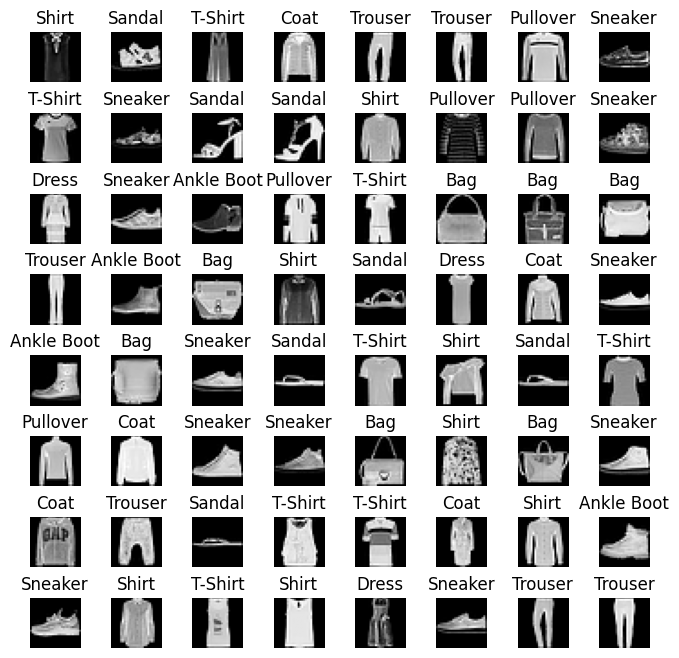

In [9]:
import matplotlib.pyplot as plt

# Tworzenie instancji datasetu dla danych treningowych i testowych
fashion_train_data = FashionMNISTDataset(train=True)
fashion_test_data = FashionMNISTDataset(train=False)

# Użycie DataLoader do ładowania danych w batchach
train_dataloader = FashionMNISTDataLoader(
    fashion_train_data, batch_size=64, shuffle=True, num_workers=0
)
test_dataloader = FashionMNISTDataLoader(
    fashion_test_data, batch_size=64, shuffle=False, num_workers=0
)

# Test
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


figure = plt.figure(figsize=(8, 8))
cols, rows = 8, 8

# Wyświetlanie obrazów i etykiet
for i in range(1, cols * rows + 1):
    img = train_features[i - 1].squeeze()
    label = train_labels[i - 1].item()
    ax = figure.add_subplot(rows, cols, i)
    ax.set_title(fashion_train_data.labels_map[label])
    ax.axis("off")
    ax.imshow(img, cmap="gray")

plt.subplots_adjust(wspace=0.6, hspace=0.6)
plt.show()

In [13]:
# Create the data module
data_module = FashionMNISTDataModule(batch_size=64)
data_module.setup()

# Create the Wandb logger
wandb_logger = WandbLogger(project="fashion_mnist_optuna", log_model=True)


# Define an objective function for Optuna
def objective(trial):
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    model = SimpleCNN(learning_rate=lr)

    # Check if CUDA is available and set the accelerator accordingly
    accelerator = "cpu"

    trainer = L.Trainer(
        logger=wandb_logger,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_loss")],
        max_epochs=10,
        accelerator=accelerator,
        devices=1,
        log_every_n_steps=1,
    )

    trainer.fit(model, data_module)

    return trainer.callback_metrics["val_loss"].item()


# Create and optimize the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Collect losses for plotting
train_losses = []
val_losses = []
for trial in study.trials:
    train_losses.append(trial.user_attrs.get("train_loss", None))
    val_losses.append(trial.user_attrs.get("val_loss", None))

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label="Training Loss", marker="o")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Trial")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Print the best trial and parameters
print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

[I 2025-03-19 17:16:43,547] A new study created in memory with name: no-name-9672fb11-73e3-416c-af1c-d19cc4ae42ba
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[W 2025-03-19 17:16:43,581] Trial 0 failed with parameters: {'learning_rate': 0.002926610274111218} because of the following error: ModuleNotFoundError("No module named 'distutils'").
Traceback (most recent call last):
  File "c:\Users\koga.wa\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\koga.wa\AppData\Local\Temp\ipykernel_5924\3770732031.py", line 26, in objective
    trainer.fit(model, data_module)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\koga.wa\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\trainer.py", line 539, in fit
    call._call_and_handle_interrupt(
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^

ModuleNotFoundError: No module named 'distutils'